In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('../..')))

In [2]:
import numpy as np 
import scipy.fft
from operators.mixed_method_0.mixed_method_0_operators import charge_density_two_stream_mixed_method_0
from operators.legendre.legendre_operators import xi_legendre
from operators.aw_hermite.aw_hermite_operators import aw_psi_hermite, aw_psi_hermite_complement
from operators.mixed_method_1.setup_mixed_method_1_two_stream import SimulationSetupMixedMethod1
from operators.poisson_solver import gmres_solver
from operators.reprojection_between_hermite_and_legendre import reprojection_aw_hermite_and_legendre
from operators.aw_hermite.aw_hermite_operators import total_mass_aw_hermite, total_momentum_aw_hermite, total_energy_k_aw_hermite, A_matrix_Opi
from operators.legendre.legendre_operators import total_mass_legendre, total_momentum_legendre, total_energy_k_legendre

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from mycolorpy import colorlist as mcp
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

# Enable LaTeX rendering
matplotlib.rcParams['text.usetex'] = True

In [4]:
import matplotlib.cm as cm

# Get the 'inferno' colormap
inferno_cmap = cm.get_cmap('inferno')

# Sample the colormap at three different points (e.g., 25%, 50%, 75%)
color1 = inferno_cmap(0.)
color2 = inferno_cmap(0.4)
color3 = inferno_cmap(0.75)

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_13797/3987657641.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  inferno_cmap = cm.get_cmap('inferno')


# *Mixed method #1*: two-stream instability 

In [11]:
setup = SimulationSetupMixedMethod1(Nx=101,
                                        Nv_e1=64,
                                        Nv_e2=64,
                                        epsilon=1e-2,
                                        v_a=-4,
                                        v_b=4,
                                        alpha_e1=np.sqrt(2),
                                        alpha_e2=np.sqrt(2),
                                        u_e1=0,
                                        u_e2=0,
                                        L=4 * np.pi,
                                        dt=1e-2,
                                        T0=0,
                                        T=35,
                                        nu_L=1,
                                        nu_H=0,
                                        n0_e1=0.5,
                                        n0_e2=0.5,
                                        gamma=0.5,
                                        k0=0.5,
                                        Nv_int=5000,
                                        u_tol=10,
                                        alpha_tol=10,
                                        cutoff=3,
                                        threshold_last_hermite=100,
                                        construct_integrals=False)

In [12]:
# spatial grid 
x = np.linspace(0, setup.L, setup.Nx+1)
v_ = np.linspace(setup.v_a, setup.v_b, 15000, endpoint=True)

In [13]:
if setup.construct_integrals:
    fig, ax = plt.subplots(figsize=(7, 3))
    ax.plot(np.arange(setup.Nv_e2), setup.J_int[-1, :], "-o", label="$\mathcal{J}_{N_{H}, m}$")
    ax.set_yscale("symlog", linthresh=1e-10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title("$N_{H} = $" + str(setup.Nv_e1))
    ax.set_xlabel("$m$")
    legend = plt.legend()
    legend.get_frame().set_alpha(0)
    plt.tight_layout()

# simulation results

In [14]:
skip = 1
# load the simulation results
# save results
sol_midpoint_u = np.load("../../data/mixed_method_1_aw_hermite_legendre/two_stream/sol_u_NvH_" + str(setup.Nv_e1) + "_NvL_" + str(setup.Nv_e2) +
            "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")
sol_midpoint_t = np.load("../../data/mixed_method_1_aw_hermite_legendre/two_stream/sol_t_NvH_" + str(setup.Nv_e1) + "_NvL_" + str(setup.Nv_e2) +
            "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")

dt = 0.01 * skip

# print simulation dimensions
print(np.shape(sol_midpoint_u))
print(np.shape(sol_midpoint_t))

(12928, 3501)
(3501,)


In [15]:
runtime = np.load("../../data/mixed_method_1_aw_hermite_legendre/two_stream/sol_runtime_NvH_" + str(setup.Nv_e1) + "_NvL_" + str(setup.Nv_e2) +
            "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")
runtime

array([1024.044723  ,  268.27206612])

In [16]:
alpha_e1 = np.load("../../data/mixed_method_1_aw_hermite_legendre/two_stream/alpha_e1_Nve1_" + str(setup.Nv_e1)
            + "_Nve2_" + str(setup.Nv_e2) + "_Nx_" + str(setup.Nx)
            + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")

u_e1 = np.load("../../data/mixed_method_1_aw_hermite_legendre/two_stream/u_e1_Nve1_" + str(setup.Nv_e1)
            + "_Nve2_" + str(setup.Nv_e2) + "_Nx_" + str(setup.Nx)
            + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")

alpha_e1 = np.repeat(alpha_e1, len(sol_midpoint_t))
u_e1 = np.repeat(u_e1, len(sol_midpoint_t))


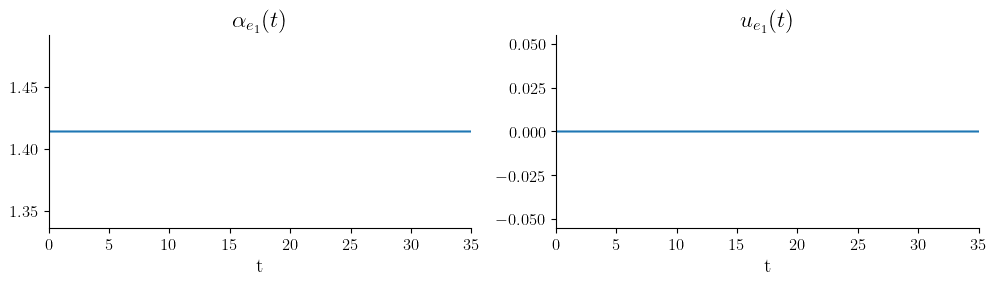

In [17]:
fig, ax  = plt.subplots(ncols=2, figsize=(12, 2.5))
ax[0].plot(sol_midpoint_t, alpha_e1)
ax[1].plot(sol_midpoint_t, u_e1)
ax[0].set_xlim(0, setup.T)
ax[1].set_xlim(0, setup.T)

ax[1].set_xlabel("t")
ax[0].set_xlabel("t")
ax[1].set_title(r"$u_{e_{1}}(t)$")
ax[0].set_title(r"$\alpha_{e_{1}}(t)$")

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

In [18]:
# initialize the electric potential
E_midpoint = np.zeros((setup.Nx + 1, len(sol_midpoint_t)))

In [19]:
# initialize the states for implicit midpoint (symplectic)
state_e_H = np.zeros((setup.Nv_e1,  setup.Nx + 1, len(sol_midpoint_t)))
state_e_L = np.zeros((setup.Nv_e2,  setup.Nx + 1, len(sol_midpoint_t)))

for ii in np.arange(0, len(sol_midpoint_t)):
    # immobile ions
    state_e_H[:, :-1, ii]  = np.reshape(sol_midpoint_u[:setup.Nv_e1*setup.Nx, ii], (setup.Nv_e1, setup.Nx)) 
    state_e_H[:, -1, ii] = state_e_H[:, 0, ii]
    # electrons species 2
    state_e_L[:, :-1, ii]  = np.reshape(sol_midpoint_u[setup.Nv_e1*setup.Nx:, ii], (setup.Nv_e2, setup.Nx))  
    state_e_L[:, -1, ii] = state_e_L[:, 0, ii]

    # solve Poisson's equation to obtain an electric field
    rho = charge_density_two_stream_mixed_method_0(q_e=setup.q_e, 
                                                   v_a=setup.v_a, v_b=setup.v_b, alpha_e=alpha_e1[ii],
                         C0_e_hermite=state_e_H[0, :setup.Nx, ii], 
                         C0_e_legendre=state_e_L[0, :setup.Nx, ii])
    
    E_midpoint[:-1, ii] = gmres_solver(rhs=rho, D=setup.D, D_inv=setup.D_inv, a_tol=1e-12, r_tol=1e-12)
    E_midpoint[-1, ii] = E_midpoint[0, ii]

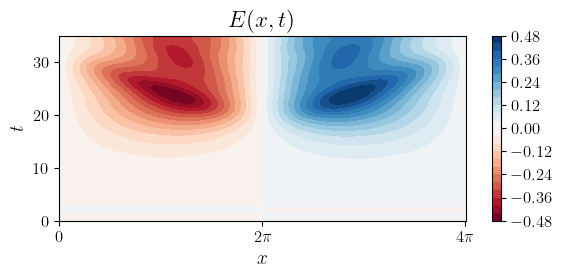

In [20]:
# plot the electric field
fig, ax = plt.subplots(figsize=(6, 3))
pos = ax.contourf(x, sol_midpoint_t, E_midpoint.T, cmap="RdBu", levels=30)
cbar = fig.colorbar(pos)
ax.set_title("$E(x, t)$")
ax.set_xlabel("$x$")
_ = ax.set_xticks([0, 2*np.pi, 4*np.pi-.05])
_ = ax.set_xticklabels([r"0", r"$2\pi$", r"$4\pi$"])
_ = ax.set_ylabel("$t$")
plt.tight_layout()

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_13797/1999439682.py:3: RuntimeWarning: divide by zero encountered in log10
  pos = ax.pcolormesh(x, sol_midpoint_t, np.log10(np.abs(state_e_H[-1, :, :])).T, cmap="RdBu", vmin=-10, vmax=1)


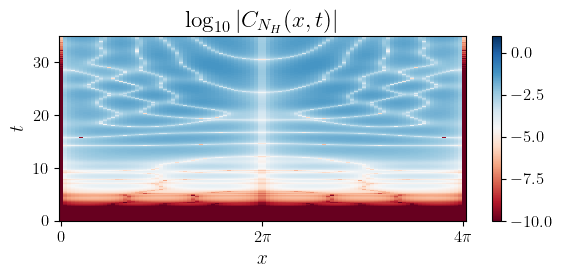

In [21]:
# plot the electric field
fig, ax = plt.subplots(figsize=(6, 3))
pos = ax.pcolormesh(x, sol_midpoint_t, np.log10(np.abs(state_e_H[-1, :, :])).T, cmap="RdBu", vmin=-10, vmax=1)
cbar = fig.colorbar(pos)
ax.set_title("$\log_{10}|C_{N_{H}}(x, t)|$")
ax.set_xlabel("$x$")
_ = ax.set_xticks([0, 2*np.pi, 4*np.pi-.05])
_ = ax.set_xticklabels([r"0", r"$2\pi$", r"$4\pi$"])
_ = ax.set_ylabel("$t$")
plt.tight_layout()

(0.0, 35.0)

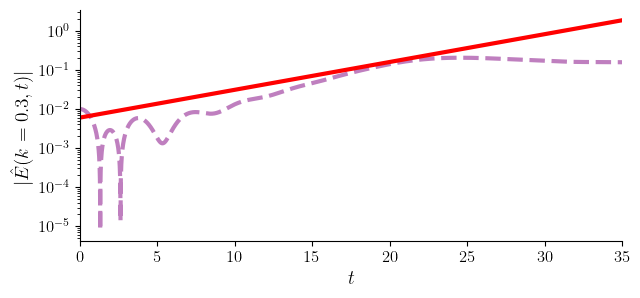

In [22]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(sol_midpoint_t, np.abs(np.fft.fft(E_midpoint, axis=0, norm="forward")[1, :]), "--", c="purple", alpha=0.5, linewidth=3, label="mixed method #1") 
ax.plot(sol_midpoint_t, 6e-3*np.exp(0.163993367317754*sol_midpoint_t), linewidth=3, color="red", label=r"theory $\gamma = 0.163993$") 

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$|\hat{E}(k=0.3, t)|$")
ax.set_xlabel("$ t$")
ax.set_xlim(0, setup.T)
#ax.set_ylim(1e-5, 1e-2)
# legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=14, loc='lower right')
# legend.get_frame().set_alpha(0)
#plt.tight_layout()
# plt.savefig("../../figures/mixed_method_1/bump_on_tail/bump_on_tail_growth_rate_legendre.png", dpi=300)

In [23]:
cmap1 = plt.get_cmap('inferno_r')
cmap2 = plt.get_cmap('inferno') # Reversed

# Combine the two colormaps to create a diverging colormap
# This creates a diverging colormap from 'inferno' and 'inferno_r'
div_cmap = colors.ListedColormap(np.vstack((cmap1(np.linspace(0, 1, 128)), cmap2(np.linspace(0, 1, 128)))))

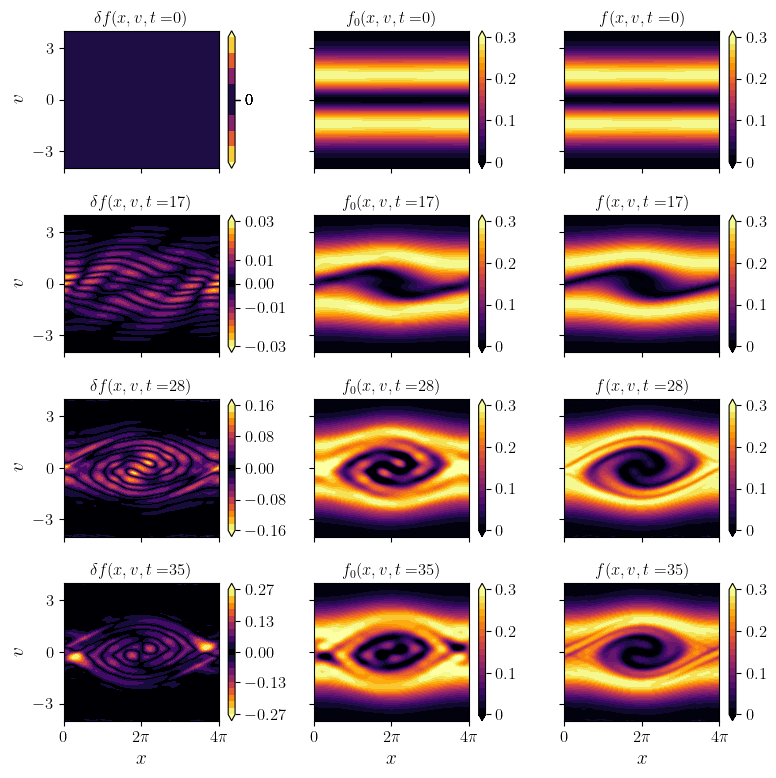

In [24]:
# plot the phase space evolution as a function of time
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(8, 8), sharex=True, sharey=True)

for tt, ii in enumerate([0, int(1*len(sol_midpoint_t)//2), int(4*len(sol_midpoint_t)//5), -1]):
    ii = int(ii)
    distribution1 = np.zeros((len(x), len(v_)))
    distribution2 = np.zeros((len(x), len(v_)))
    for jj in range(setup.Nv_e1):
        distribution1 += np.outer(state_e_H[jj, :, ii], aw_psi_hermite(v=v_, u_s=u_e1[ii], alpha_s=alpha_e1[ii], n=jj))
    for jj in range(setup.Nv_e2):
        distribution2 += np.outer(state_e_L[jj, :, ii], xi_legendre(v=v_, v_b=setup.v_b, v_a=setup.v_a, n=jj))
    if tt== 0:
        pos2 = ax[tt, 0].contourf(x, v_, distribution2.T, cmap=div_cmap, extend="both")
    else:
        pos2 = ax[tt, 0].contourf(x, v_, distribution2.T, cmap=div_cmap, levels=np.linspace(-np.max(np.abs(distribution2)), np.max(np.abs(distribution2)), 20), extend="both", 
                                  vmin=-np.max(np.abs(distribution2)), vmax=np.max(np.abs(distribution2)))
    pos1 = ax[tt, 1].contourf(x, v_, distribution1.T, cmap='inferno', vmin=0, vmax=0.3, levels=np.linspace(0, 0.3, 20), extend="both")
    pos3 = ax[tt, 2].contourf(x, v_, distribution1.T + distribution2.T, cmap='inferno', vmin=0, vmax=0.3, levels=np.linspace(0, 0.3, 20), extend="both")
    ax[tt, 0].set_yticks([-3, 0, 3, 6])
    ax[tt, 0].set_ylim(-4, 4)
    ax[tt, 0].set_ylabel("$v$")
    cbar = fig.colorbar(pos1)
    ax[tt, 1].set_title('$f_{0}(x, v, t=$' + str(int(sol_midpoint_t[ii])) + ")", fontsize=12)
    cbar.ax.set_yticks([0, 0.1, 0.2, 0.3])
    cbar.ax.set_yticklabels(["0", "0.1", "0.2", "0.3"])

    cbar = fig.colorbar(pos2)
    ax[tt, 0].set_title('$\delta f(x, v, t=$' + str(int(sol_midpoint_t[ii])) + ")", fontsize=12)
    cbar.ax.set_yticks(np.round(np.linspace(-np.max(np.abs(distribution2)), np.max(np.abs(distribution2)), 5), 2))

    cbar = fig.colorbar(pos3)
    ax[tt, 2].set_title('$f(x, v, t=$' + str(int(sol_midpoint_t[ii])) + ")", fontsize=12)
    cbar.ax.set_yticks([0, 0.1, 0.2, 0.3])
    cbar.ax.set_yticklabels(["0", "0.1", "0.2", "0.3"])
    
ax[tt, 0].set_xlabel("$x$")
ax[tt, 0].set_xticks([0, 2*np.pi, 4*np.pi])
ax[tt, 0].set_xticklabels([r"0", r"2$\pi$", r"$4\pi$"])
ax[tt, 2].set_xlabel("$x$")
ax[tt, 1].set_xlabel("$x$")

plt.tight_layout()
plt.savefig("../../figures/mixed_method_1/two_stream/two_stream_evolution_mixed_method_1_NH_" + str(setup.Nv_e1)+ ".png", dpi=700)

In [25]:
np.save("../../data/mixed_method_1_aw_hermite_legendre/two_stream/distribution_t_35_" + str(setup.Nv_e1) + "_NvL_" + str(setup.Nv_e2) +
            "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy", distribution1 + distribution2)

In [26]:
np.save("../../data/mixed_method_1_aw_hermite_legendre/two_stream/E_field_" + str(setup.Nv_e1) + "_NvL_" + str(setup.Nv_e2) +
            "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy", E_midpoint)

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_13797/189670229.py:2: RuntimeWarning: divide by zero encountered in log10
  pos = ax[0].pcolormesh(np.arange(0, setup.Nv_e1), sol_midpoint_t, np.log10(np.abs(np.fft.fft(state_e_H, axis=1)[:, 1, :])).T, vmin=-5, vmax=1)
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_13797/189670229.py:4: RuntimeWarning: divide by zero encountered in log10
  pos = ax[1].pcolormesh(np.arange(0, setup.Nv_e2), sol_midpoint_t, np.log10(np.abs(np.fft.fft(state_e_L, axis=1)[:, 1, :])).T, vmin=-5, vmax=1)


Text(0.5, 1.0, '$\\log_{10}|B|$')

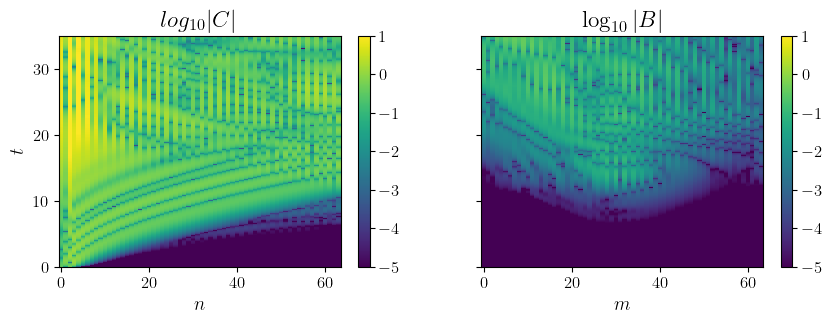

In [27]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(10, 3))
pos = ax[0].pcolormesh(np.arange(0, setup.Nv_e1), sol_midpoint_t, np.log10(np.abs(np.fft.fft(state_e_H, axis=1)[:, 1, :])).T, vmin=-5, vmax=1)
cbar = fig.colorbar(pos)
pos = ax[1].pcolormesh(np.arange(0, setup.Nv_e2), sol_midpoint_t, np.log10(np.abs(np.fft.fft(state_e_L, axis=1)[:, 1, :])).T, vmin=-5, vmax=1)
cbar = fig.colorbar(pos)
ax[0].set_xlabel("$n$")
ax[1].set_xlabel("$m$")
ax[0].set_ylabel("$t$")
ax[0].set_ylabel("$t$")
ax[0].set_title("$log_{10}|C|$")
ax[1].set_title("$\log_{10}|B|$")

# conservation laws: mass, momentum, and energy

### mass conservation

In [24]:
# compute mass at each timestamp
mass_midpoint_H = np.zeros(len(sol_midpoint_t))
mass_midpoint_L = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    mass_midpoint_H[ii] = total_mass_aw_hermite(state=state_e_H[:, :-1, ii], alpha_s=alpha_e1[ii], dx=setup.dx)
    mass_midpoint_L[ii] = total_mass_legendre(state=state_e_L[:, :-1, ii], v_a=setup.v_a, v_b=setup.v_b, dx=setup.dx)

mass_midpoint = mass_midpoint_L + mass_midpoint_H

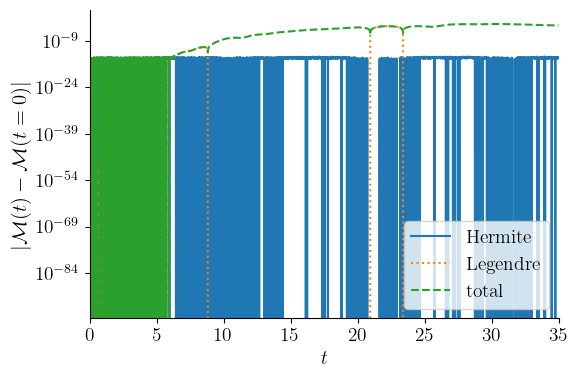

In [25]:
# plot mass conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, mass_midpoint_H - mass_midpoint_H[0], "-", label="Hermite")
ax.plot(sol_midpoint_t, mass_midpoint_L - mass_midpoint_L[0], ":", label="Legendre")
ax.plot(sol_midpoint_t, np.abs(mass_midpoint - mass_midpoint[0]), "--", label="total")
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{M}(t) - \mathcal{M}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.legend()
ax.set_xlim(setup.T0, setup.T)
plt.tight_layout()

### momentum conservation

In [26]:
# compute momentum at each timestamp
momentum_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    momentum_midpoint[ii] = total_momentum_aw_hermite(state=state_e_H[:, :-1, ii], alpha_s=alpha_e1[ii], u_s=u_e1[ii],
                                                   dx=setup.dx, m_s=setup.m_e)\
                            +total_momentum_legendre(state=state_e_L[:, :-1, ii], v_a=setup.v_a, v_b=setup.v_b, dx=setup.dx, m_s=setup.m_e)

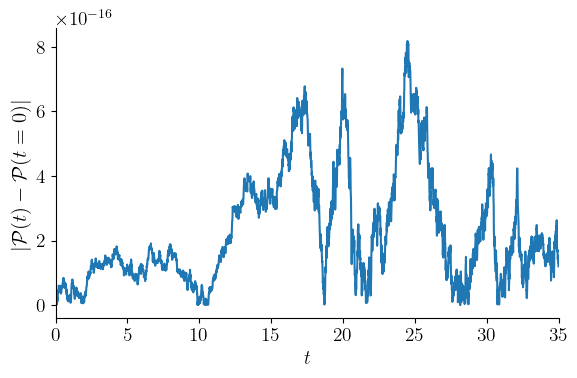

In [27]:
# plot momentum conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(momentum_midpoint - momentum_midpoint[0]), "-")
#ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{P}(t)-\mathcal{P}(t=0)|$", fontsize=15)
ax.set_xlim(setup.T0, setup.T)
ax.set_xlabel("$t$")
plt.tight_layout()

### energy conservation

In [28]:
# compute energy (kinetic + potential) at each timestamp
energy_k_midpoint = np.zeros(len(sol_midpoint_t))
energy_p_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    energy_k_midpoint[ii] = total_energy_k_aw_hermite(state=state_e_H[:, :-1, ii], alpha_s=alpha_e1[ii],
                                                   u_s=u_e1[ii], dx=setup.dx, m_s=setup.m_e)\
                           +total_energy_k_legendre(state=state_e_L[:, :-1, ii], v_a=setup.v_a, v_b=setup.v_b, dx=setup.dx, m_s=setup.m_e)
    
    energy_p_midpoint[ii] = 0.5*setup.dx*np.sum((E_midpoint[:-1, ii])**2)

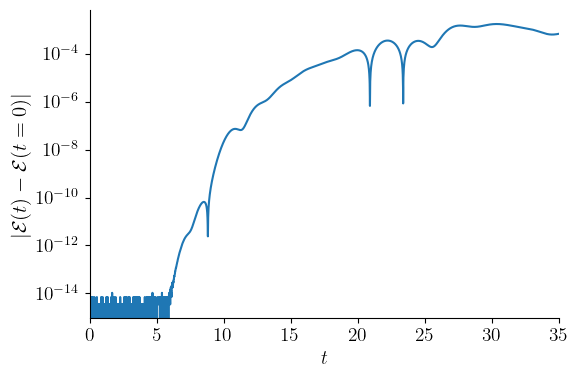

In [29]:
# plot energy conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0]), "-")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{E}(t)-\mathcal{E}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(setup.T0, setup.T)
ax.set_yscale("log")
plt.tight_layout()

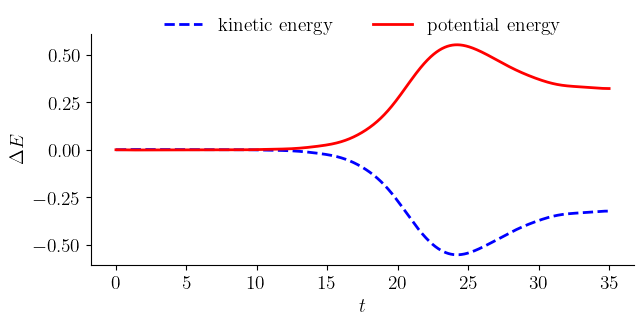

In [30]:
# plot the (kinetic + potential) energy exchange
fig, ax = plt.subplots(figsize=(7, 3))
plt.plot(sol_midpoint_t, energy_k_midpoint- energy_k_midpoint[0], label="kinetic energy", ls="--", linewidth=2, color="blue")
plt.plot(sol_midpoint_t, energy_p_midpoint- energy_p_midpoint[0], label="potential energy", linewidth=2, color="red")
legend = ax.legend(ncols=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.15))
legend.get_frame().set_alpha(0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("$t$")
_ = ax.set_ylabel(r"$\Delta E$")

### conservation summary

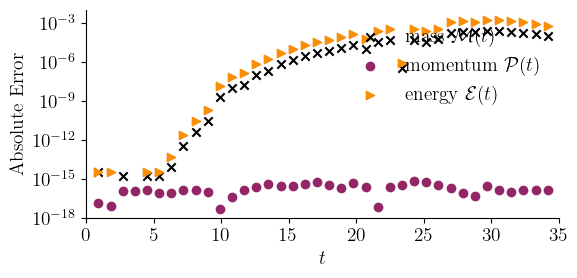

In [31]:
# plot the analytic and numerical conservation properties
skip = 90

fig, ax = plt.subplots(figsize=(6, 3))
ax.scatter(sol_midpoint_t[::skip], np.abs(mass_midpoint-mass_midpoint[0])[::skip], marker="x", color=color1, label=r"mass $\mathcal{M}(t)$")
ax.scatter(sol_midpoint_t[::skip], np.abs(momentum_midpoint-momentum_midpoint[0])[::skip], marker="o", color=color2, label=r"momentum $\mathcal{P}(t)$")
ax.scatter(sol_midpoint_t[::skip], np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0])[::skip], marker=">", color=color3, label=r"energy $\mathcal{E}(t)$")

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"Absolute Error")
ax.set_xlabel("$t$")
ax.set_xlim(setup.T0, setup.T)
ax.set_yscale("log")
legend = ax.legend(ncols=1, fontsize=14, loc='upper right')
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
legend.get_frame().set_alpha(0)
ax.set_yticks([1e-3, 1e-6, 1e-9, 1e-12, 1e-15, 1e-18])
ax.set_ylim(1e-18, 1e-2)
plt.tight_layout()
plt.savefig("../../figures/mixed_method_1/two_stream/two_stream_conservation_" + str(setup.Nv_e1) + ".png", dpi=600)

In [32]:
L2_midpoint = np.zeros(len(sol_midpoint_t))

A = np.kron(A_matrix_Opi(N=setup.Nv_e1, alpha=alpha_e1[ii]), np.eye(setup.Nx))

for ii in range(0, len(sol_midpoint_t)):
    L2_midpoint[ii] = sol_midpoint_u[:setup.Nv_e1*setup.Nx, ii].T @ A @ sol_midpoint_u[:setup.Nv_e1*setup.Nx, ii]

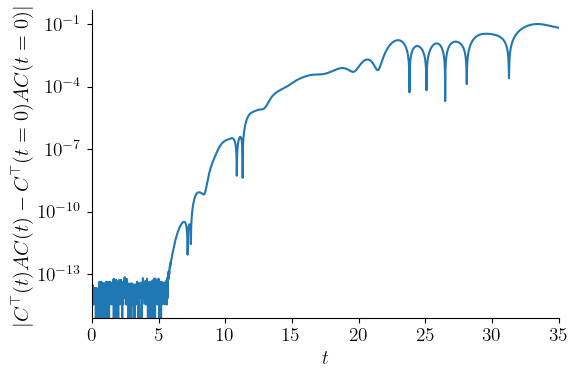

In [33]:
# plot mass conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(L2_midpoint - L2_midpoint[0]), "-")
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|C^{\top}(t)A C(t) - C^{\top}(t=0) A C(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(setup.T0, setup.T)
plt.tight_layout()
plt.savefig("../../figures/mixed_method_1/two_stream/L2_norm_weight_" + str(setup.Nv_e1) + "_one_stream.png", dpi=300)